For Data collection

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np

# Setup directories
DATA_DIR = './new'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# MediaPipe Hand Detection Setup
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Webcam setup
cap = cv2.VideoCapture(0)

number_of_classes = 36
dataset_size = 200  # Total images per class
images_per_hand = 100  # Images per hand

for j in range(number_of_classes):
    class_dir = os.path.join(DATA_DIR, str(j))
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    print(f"Collecting data for class {j}. Press 'Q' to start.")

    # Start collecting
    while True:
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.flip(frame, 1)  # Flip the camera feed
        cv2.putText(frame, 'Press "Q" to start capturing', (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Capture images for the first and second hands
    for hand in range(2):  # 0 for first hand, 1 for second hand
        counter = 0
        while counter < images_per_hand:
            ret, frame = cap.read()
            if not ret:
                continue
            frame = cv2.flip(frame, 1)  # Flip the camera feed

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb_frame)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Draw hand landmarks
                    mp_drawing.draw_landmarks(
                        frame,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_drawing_styles.get_default_hand_landmarks_style(),
                        mp_drawing_styles.get_default_hand_connections_style()
                    )

                    # Get bounding box around the hand
                    h, w, _ = frame.shape
                    x_min, y_min = w, h
                    x_max, y_max = 0, 0

                    for landmark in hand_landmarks.landmark:
                        x, y = int(landmark.x * w), int(landmark.y * h)
                        x_min = min(x_min, x)
                        y_min = min(y_min, y)
                        x_max = max(x_max, x)
                        y_max = max(y_max, y)

                    # Expand bounding box slightly
                    margin = 20
                    x_min = max(0, x_min - margin)
                    y_min = max(0, y_min - margin)
                    x_max = min(w, x_max + margin)
                    y_max = min(h, y_max + margin)

                    # Crop hand region
                    hand_crop = frame[y_min:y_max, x_min:x_max]

                    if hand_crop.size == 0:
                        continue

                    # Convert to grayscale
                    gray = cv2.cvtColor(hand_crop, cv2.COLOR_BGR2GRAY)

                    # Threshold to binary image
                    _, binary_img = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

                    # Display and save the binary image
                    cv2.imshow('frame', binary_img)
                    img_path = os.path.join(class_dir, f'{j * 2 + hand}_{counter}.jpg')
                    cv2.imwrite(img_path, binary_img)

                    counter += 1
                    if counter >= images_per_hand:
                        break

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # After capturing 100 images for one hand, prompt to change hands
        if hand == 0:
            print(f"Captured {counter} images for class {j}.")
            while True:
                ret, frame = cap.read()
                if not ret:
                    continue
                frame = cv2.flip(frame, 1)  # Flip the camera feed
                cv2.putText(frame, 'Press "Q" to switch hands or "Y" to stop', (50, 50), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.imshow('frame', frame)
                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):
                    break
                elif key == ord('y'):
                    counter = images_per_hand
                    break

    # After capturing all images for the class
    print(f"Captured {dataset_size} images for class {j}.")
    if j < number_of_classes - 1:
        while True:
            ret, frame = cap.read()
            if not ret:
                continue
            frame = cv2.flip(frame, 1)  # Flip the camera feed
            cv2.putText(frame, 'Press "Y" to continue to the next class or "N" to stop', (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('frame', frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('y'):
                break
            elif key == ord('n'):
                cap.release()
                cv2.destroyAllWindows()
                hands.close()
                exit()

# Cleanup
cap.release()
cv2.destroyAllWindows()
hands.close()


Working Model creation and prediction

Working prediction and Word suggestion

In [5]:
# Import necessary libraries
import os
import cv2  # OpenCV for image processing
import numpy as np  # For numerical operations
import mediapipe as mp  # For hand detection and tracking
import tensorflow as tf  # For loading trained models
from keras.models import Sequential  # Model architecture
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # CNN layers
from keras.utils import to_categorical  # Convert labels to one-hot encoding
from sklearn.model_selection import train_test_split  # Split dataset
from keras.callbacks import ModelCheckpoint  # To save the best model

import time  # For tracking prediction timing

# Constants and settings
DATA_DIR = './data'  # Path to training data folders (one per class)
IMG_SIZE = (64, 64)  # Input image size
NUM_CLASSES = 26  # 26 letters 
BATCH_SIZE = 64
EPOCHS = 50
PREDICTION_DELAY = 2.5  # Seconds required to confirm a prediction
WORD_FILE = 'words.txt'  # Dictionary file path

# Region in the top-left of the screen to monitor for the left hand
TOP_LEFT_REGION = (0, 0, 480, 360)  # Expanded from 320x240

# Function to load data from folder structure
def load_data():
    X = []  # Image data
    y = []  # Labels

    # Loop through class folders
    for class_dir in os.listdir(DATA_DIR):
        class_path = os.path.join(DATA_DIR, class_dir)
        if not os.path.isdir(class_path):
            continue

        class_label = int(class_dir)  # Convert folder name to label
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            img = cv2.resize(img, IMG_SIZE)  # Resize to 64x64
            X.append(img)
            y.append(class_label)

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # Normalize pixel values
    X = X.astype('float32') / 255.0
    X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)  # Add channel dimension

    y = to_categorical(y, NUM_CLASSES)  # One-hot encode labels

    # Split into training and testing sets
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model architecture
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # Flatten output
    model.add(Dense(64, activation='relu'))  # Fully connected layer
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(NUM_CLASSES, activation='softmax'))  # Output layer

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train the model and save best version
def train_model():
    X_train, X_test, y_train, y_test = load_data()
    model = create_model()

    # Save model only when validation accuracy improves
    checkpoint = ModelCheckpoint('hand_sign_model.h5',
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 verbose=1)

    # Train the model
    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpoint])

    # Load best weights
    model.load_weights('hand_sign_model.h5')
    return model, history

# Load words from dictionary file
def load_dictionary(path=WORD_FILE):
    if not os.path.exists(path):
        print(f"Dictionary file '{path}' not found!")
        return []
    with open(path, 'r') as file:
        words = [line.strip().upper() for line in file if line.strip().isalpha()]
    return words

# Return up to 4 suggestions based on current word
def get_suggestions(current_word, dictionary, stored_letters, max_suggestions=4):
    if not current_word:
        return []
    suggestions = [word for word in dictionary if word.startswith(current_word)]
    
    # If no suggestions, combine stored letters into one suggestion
    if not suggestions and stored_letters:
        combined_suggestion = ''.join(stored_letters)
        return [combined_suggestion]  # Return as a single suggestion

    return suggestions[:max_suggestions]

# Count number of extended fingers
def count_fingers(hand_landmarks, hand_label):
    finger_tips = [4, 8, 12, 16, 20]  # Thumb to pinky tips
    fingers = []

    # Thumb logic is different (horizontal direction)
    if hand_label == "Right":
        fingers.append(hand_landmarks.landmark[finger_tips[0]].x < hand_landmarks.landmark[finger_tips[0] - 1].x)
    else:
        fingers.append(hand_landmarks.landmark[finger_tips[0]].x > hand_landmarks.landmark[finger_tips[0] - 1].x)

    # Other fingers: vertical direction
    for tip in finger_tips[1:]:
        fingers.append(hand_landmarks.landmark[tip].y < hand_landmarks.landmark[tip - 2].y)
    return sum(fingers)  # Count of fingers up

# Check if hand is inside the defined top-left region
def is_hand_in_top_left(hand_landmarks, frame_width, frame_height):
    x, y, w, h = TOP_LEFT_REGION
    for lm in hand_landmarks.landmark:
        px, py = int(lm.x * frame_width), int(lm.y * frame_height)
        if not (x <= px <= x + w and y <= py <= y + h):
            return False
    return True

# Live video capture and prediction function
def predict_hand_sign():
    model = tf.keras.models.load_model('hand_sign_model.h5')  # Load trained model
    dictionary = load_dictionary()  # Load word list

    # Initialize MediaPipe
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_styles = mp.solutions.drawing_styles
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2,
                           min_detection_confidence=0.7, min_tracking_confidence=0.7)

    # Class label mapping
    class_names = [
        "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
        "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T",
        "U", "V", "W", "X", "Y", "Z"
    ]

    cap = cv2.VideoCapture(0)  # Start webcam

    # Variables to manage predictions and sentence building
    last_predicted_letter = ""
    last_prediction_time = time.time()
    stored_letters = []
    sentence = ""
    confirmed_letter = ""
    confirmed_confidence = 0.0

    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        frame = cv2.flip(frame, 1)  # Mirror the frame
        h_frame, w_frame = frame.shape[:2]

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        results = hands.process(rgb)  # Run hand detection

        current_word = ''.join(stored_letters)
        suggestions = get_suggestions(current_word, dictionary, stored_letters)  # Updated call
        finger_count_right = 0

        # Draw top-left region box
        x, y, w, h = TOP_LEFT_REGION
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Empty binary image
        binary_img = np.zeros((h, w), dtype=np.uint8)

        predicted_letter = ""
        confidence = 0.0

        # Process detected hands
        if results.multi_hand_landmarks and results.multi_handedness:
            for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
                label = results.multi_handedness[idx].classification[0].label

                # Draw hand landmarks
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_styles.get_default_hand_landmarks_style(),
                    mp_styles.get_default_hand_connections_style()
                )

                # Count right-hand fingers
                if label == "Right":
                    finger_count_right = count_fingers(hand_landmarks, label)

                # Predict from left hand in top-left region
                if label == "Left" and is_hand_in_top_left(hand_landmarks, w_frame, h_frame):
                    x_min, y_min, x_max, y_max = w_frame, h_frame, 0, 0
                    for lm in hand_landmarks.landmark:
                        px, py = int(lm.x * w_frame), int(lm.y * h_frame)
                        x_min = min(x_min, px)
                        y_min = min(y_min, py)
                        x_max = max(x_max, px)
                        y_max = max(y_max, py)

                    # Add margin around hand
                    margin = 20
                    x_min = max(0, x_min - margin)
                    y_min = max(0, y_min - margin)
                    x_max = min(w_frame, x_max + margin)
                    y_max = min(h_frame, y_max + margin)

                    hand_crop = frame[y_min:y_max, x_min:x_max]
                    if hand_crop.size == 0:
                        continue

                    # Convert to binary threshold image
                    gray = cv2.cvtColor(hand_crop, cv2.COLOR_BGR2GRAY)
                    _, binary_img = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
                    input_img = cv2.resize(binary_img, IMG_SIZE).astype('float32') / 255.0
                    input_img = input_img.reshape(1, 64, 64, 1)

                    # Predict using model
                    prediction = model.predict(input_img)
                    predicted_idx = np.argmax(prediction)
                    predicted_letter = class_names[predicted_idx]
                    confidence = float(np.max(prediction))

                    # Confirm prediction if held long enough
                    if time.time() - last_prediction_time >= PREDICTION_DELAY:
                        if predicted_letter == last_predicted_letter:
                            stored_letters.append(predicted_letter)
                        else:
                            last_predicted_letter = predicted_letter
                        last_prediction_time = time.time()

                    confirmed_letter = predicted_letter
                    confirmed_confidence = confidence

        # Overlay binary image onto frame
        binary_resized = cv2.resize(binary_img, (w, h))
        frame[y:y + h, x:x + w] = cv2.cvtColor(binary_resized, cv2.COLOR_GRAY2BGR)

        # Show current confirmed prediction
        if confirmed_letter:
            cv2.putText(frame, f'Predicted: {confirmed_letter} ({confirmed_confidence:.2f})',
                        (10, h_frame - 120), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 165, 255), 2)

        # Show stored letters and suggestions
        cv2.putText(frame, f'Stored: {"".join(stored_letters)}', (10, h_frame - 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        for i, suggestion in enumerate(suggestions):
            text = f'{i + 1}. {suggestion}'
            x_pos = w_frame - 200
            y_pos = 30 + i * 30
            cv2.putText(frame, text, (x_pos, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        if len(suggestions) > 0:
            delete_text = "5. Delete"
            cv2.putText(frame, delete_text, (w_frame - 200, 30 + 4 * 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # Display current sentence
        cv2.putText(frame, f'Sentence: {sentence}', (10, h_frame - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        # Handle suggestion selection with fingers
        if 1 <= finger_count_right <= len(suggestions):
            sentence += suggestions[finger_count_right - 1] + " "
            stored_letters = []  # Clear word buffer
            time.sleep(1)  # Pause to avoid multiple triggers
        elif finger_count_right == 5:
            if stored_letters:
                stored_letters.pop()  # Remove last letter
                time.sleep(1)

        cv2.imshow("Hand Sign Recognition", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Quit on 'q' key
            break

    cap.release()
    cv2.destroyAllWindows()
    hands.close()

# model, history = train_model()

# predict_hand_sign()

In [6]:
model, history = train_model()

c:\Users\tejas\anaconda3\envs\handsign-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.1932 - loss: 2.7899
Epoch 1: val_accuracy improved from -inf to 0.98999, saving model to hand_sign_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 653ms/step - accuracy: 0.1954 - loss: 2.7821 - val_accuracy: 0.9900 - val_loss: 0.1120
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8204 - loss: 0.5490
Epoch 2: val_accuracy improved from 0.98999 to 0.99666, saving model to hand_sign_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 77s 599ms/step - accuracy: 0.8207 - loss: 0.5481 - val_accuracy: 0.9967 - val_loss: 0.0249
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8926 - loss: 0.3107
Epoch 3: val_accuracy did not improve from 0.99666
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 444ms/step - accuracy: 0.8927 - loss: 0.3104 - val_accuracy: 0.9967 - val_loss: 0.0215
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9177 - loss: 0.2578
Epoch 4: val_accuracy did not improve from 0.99666
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - accuracy: 0.9177 - loss: 0.2576 - val_accuracy: 0.9967 - val_loss: 0.0169
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9369 - loss: 0.1754
Epoch 5: val_accuracy improved from 0.99666 to 0.99733, saving model to hand_sign_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 575ms/step - accuracy: 0.9368 - loss: 0.1756 - val_accuracy: 0.9973 - val_loss: 0.0201
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.9394 - loss: 0.1662
Epoch 6: val_accuracy did not improve from 0.99733
94/94 ━━━━━━━━━━━━━━━━━━━━ 96s 671ms/step - accuracy: 0.9394 - loss: 0.1663 - val_accuracy: 0.9973 - val_loss: 0.0223
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9505 - loss: 0.1331
Epoch 7: val_accuracy did not improve from 0.99733
94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 541ms/step - accuracy: 0.9504 - loss: 0.1333 - val_accuracy: 0.9973 - val_loss: 0.0230
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9512 - loss: 0.1416
Epoch 8: val_accuracy did not improve from 0.99733
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 476ms/step - accuracy: 0.9512 - loss: 0.1416 - val_accuracy: 0.9967 - val_loss: 0.0237
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9500 - loss: 0.1394
Epoch 9: val_accuracy did not i

94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 485ms/step - accuracy: 0.9605 - loss: 0.1045 - val_accuracy: 0.9980 - val_loss: 0.0159
Epoch 15/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9595 - loss: 0.1033
Epoch 15: val_accuracy did not improve from 0.99800
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 466ms/step - accuracy: 0.9595 - loss: 0.1033 - val_accuracy: 0.9973 - val_loss: 0.0190
Epoch 16/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9591 - loss: 0.1117
Epoch 16: val_accuracy did not improve from 0.99800
94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 547ms/step - accuracy: 0.9591 - loss: 0.1117 - val_accuracy: 0.9967 - val_loss: 0.0151
Epoch 17/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9628 - loss: 0.0972
Epoch 17: val_accuracy did not improve from 0.99800
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 491ms/step - accuracy: 0.9628 - loss: 0.0972 - val_accuracy: 0.9980 - val_loss: 0.0227
Epoch 18/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9617 - loss: 0.0990
Epoch 18: val_accuracy d

In [12]:
predict_hand_sign()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

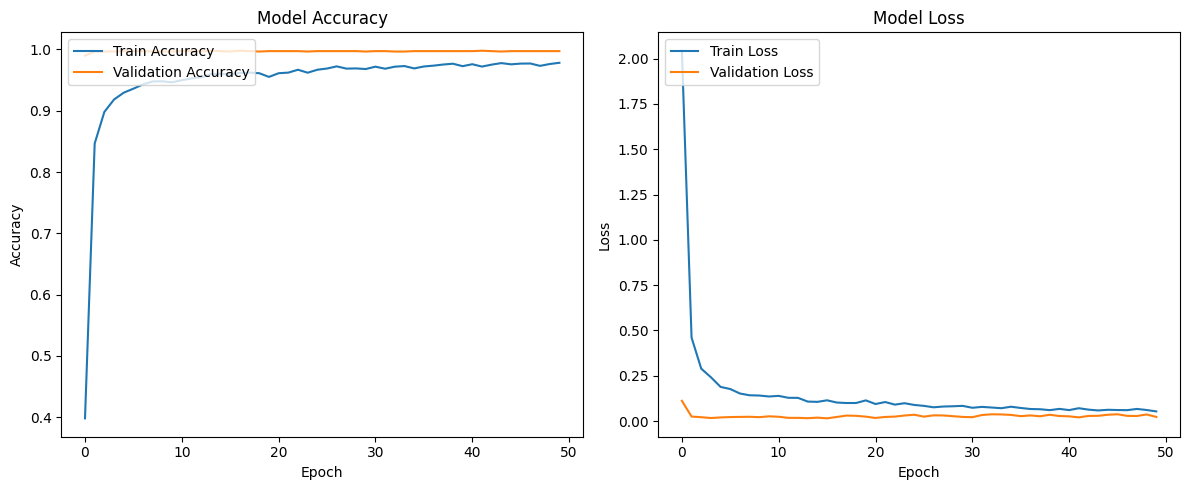

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()


plot_training_history(history)

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix
class_names = [str(i) for i in range(NUM_CLASSES)]  # Adjust this if you have specific class names
plot_confusion_matrix(conf_matrix, class_names)

NameError: name 'y_true' is not defined

In [9]:
from sklearn.metrics import f1_score

f1_scores = f1_score(y_true, y_pred_classes, average=None)  # Calculate F1 score for each class

plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), f1_scores)
plt.xticks(range(num_classes), [f'Class {i}' for i in range(num_classes)], rotation=45)
plt.title('F1 Score for Each Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

NameError: name 'y_true' is not defined

In [10]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report
report = classification_report(y_true, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt='.2f', cmap='Blues')
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

NameError: name 'y_true' is not defined

In [6]:
predict_hand_sign()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━